In [1]:
import neurokit2 as nk
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import functions
from sklearn.base import BaseEstimator,TransformerMixin
from biosppy.signals import ecg
from scipy.fftpack import fft

In [2]:
trainX = pd.read_csv("data/X_train.csv").drop(columns=["id"])
trainy = pd.read_csv("data/y_train.csv").drop(columns=["id"])
testX = pd.read_csv("data/X_test.csv").drop(columns=["id"])

In [3]:
trainX.astype(np.float16)
testX.astype(np.float16)

x0      x1      x2      x3      x4      x5      x6     x7     x8  \
0       30.0    29.0    28.0    27.0    26.0    24.0    24.0   28.0   38.0   
1      -75.0   -72.0   -70.0   -67.0   -64.0   -61.0   -59.0  -56.0  -53.0   
2      264.0   280.0   289.0   293.0   298.0   302.0   306.0  308.0  309.0   
3     -377.0  -380.0  -383.0  -385.0  -388.0  -391.0  -394.0 -397.0 -400.0   
4      -69.0   -67.0   -66.0   -65.0   -65.0   -66.0   -68.0  -70.0  -73.0   
...      ...     ...     ...     ...     ...     ...     ...    ...    ...   
3406   -21.0   -68.0   -93.0  -113.0  -127.0  -134.0  -138.0 -141.0 -143.0   
3407  -122.0  -116.0  -112.0  -111.0  -110.0  -109.0  -108.0 -108.0 -107.0   
3408    -9.0    -7.0    -5.0    -3.0    -1.0     0.0     2.0    7.0   11.0   
3409    31.0    28.0    26.0    23.0    22.0    20.0    18.0   16.0   14.0   
3410  1659.0  1577.0  1484.0  1375.0  1260.0  1150.0  1051.0  965.0  895.0   

         x9  ...  x17832  x17833  x17834  x17835  x17836  x17837  x17838  \
0      49.0  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1     -51.0  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2     310.0  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    -402.0  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4     -76.0  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
...     ...  ...     ...     ...     ...     ...     ...     ...     ...   
3406 -144.0  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3407 -107.0  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3408   13.0  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3409   11.0  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3410  862.0  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

      x17839  x17840  x17841  
0        NaN     NaN     NaN  
1        NaN     NaN     NaN  
2        NaN     NaN     NaN  
3        NaN     NaN     NaN  
4        NaN     NaN     NaN  
...      ...     ...     ...  
3406     NaN     NaN     NaN  
3407     NaN     NaN     NaN  
3408     NaN     NaN     NaN  
3409     NaN     NaN     NaN  
3410     NaN     NaN     NaN  

[3411 rows x 17842 columns]

In [4]:
def removeNans(data):
    trainX_aug = []
    for i in tqdm.trange(0,len(data)):
        lastIdx = data.iloc[i].index.get_loc(data.iloc[i,:].last_valid_index())
        trainX_aug.append(data.iloc[i,0:lastIdx])
    trainX_aug = np.array(trainX_aug)
    return trainX_aug

In [5]:
new_trainX = removeNans(trainX)

100%|██████████████████████████████████████████████████████████████████████████████| 5117/5117 [05:00<00:00, 17.03it/s]
<ipython-input-4-6cf82b3ee46d>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  trainX_aug = np.array(trainX_aug)


In [6]:
signals = pd.DataFrame()
for i in tqdm.trange(0,len(new_trainX)):
    signals = signals.append({"ECG_BioSPPy" : nk.ecg_clean(new_trainX[i], sampling_rate=300, method="biosppy")},ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████| 5117/5117 [01:30<00:00, 56.47it/s]


In [7]:
trainy3 = trainy[trainy["y"] != 3]
cleanedX = signals["ECG_BioSPPy"]
trainX3 = cleanedX[trainy["y"] != 3]
trainX3 = trainX3.to_frame().iloc[:,0]

print(trainX3.iloc[0].shape)

(16278,)


In [10]:
for i in tqdm.trange(0,len(trainX3)): 
    info = ecg.ecg(trainX3.iloc[i], sampling_rate =300, show=False)
    template = np.mean(info[4],axis=0)
    template_fft_values = np.abs(fft(template))
    

100%|██████████| 4947/4947 [03:16<00:00, 25.20it/s]


In [8]:
# create the data set
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pywt

fs = 300
sgn_length = 2000   #65536   Pay atention with ram memory! 
size_dataset = int(len(trainX3))
scales = range(1, fs)
waveletname = 'morl'
 
X_full = np.ndarray(shape=(size_dataset, fs-1, fs-1), dtype=np.float16)
                 
for i in range(0, size_dataset):
    if i % 10 == 0:
        print (i, 'done!')
    signal = trainX3.iloc[i]
    coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
    X_full[i, :, :] = coeff[:,:fs-1]

0 done!
10 done!
20 done!
30 done!
40 done!
50 done!
60 done!
70 done!
80 done!
90 done!
100 done!
110 done!
120 done!
130 done!
140 done!
150 done!
160 done!
170 done!
180 done!
190 done!
200 done!
210 done!
220 done!
230 done!
240 done!
250 done!
260 done!
270 done!
280 done!
290 done!
300 done!
310 done!
320 done!
330 done!
340 done!
350 done!
360 done!
370 done!
380 done!
390 done!
400 done!
410 done!
420 done!
430 done!
440 done!
450 done!
460 done!
470 done!
480 done!
490 done!
500 done!
510 done!
520 done!
530 done!
540 done!
550 done!
560 done!
570 done!
580 done!
590 done!
600 done!
610 done!
620 done!
630 done!
640 done!
650 done!
660 done!
670 done!
680 done!
690 done!
700 done!
710 done!
720 done!
730 done!
740 done!
750 done!
760 done!
770 done!
780 done!
790 done!
800 done!
810 done!
820 done!
830 done!
840 done!
850 done!
860 done!
870 done!
880 done!
890 done!
900 done!
910 done!
920 done!
930 done!
940 done!
950 done!
960 done!
970 done!
980 done!
990 done!
1000 done!


<ipython-input-13-cfeca8bc457d>:9: RuntimeWarning: overflow encountered in multiply
  plt.imshow((X_full[index]*255).astype(np.uint8), cmap="binary", interpolation="spline36")


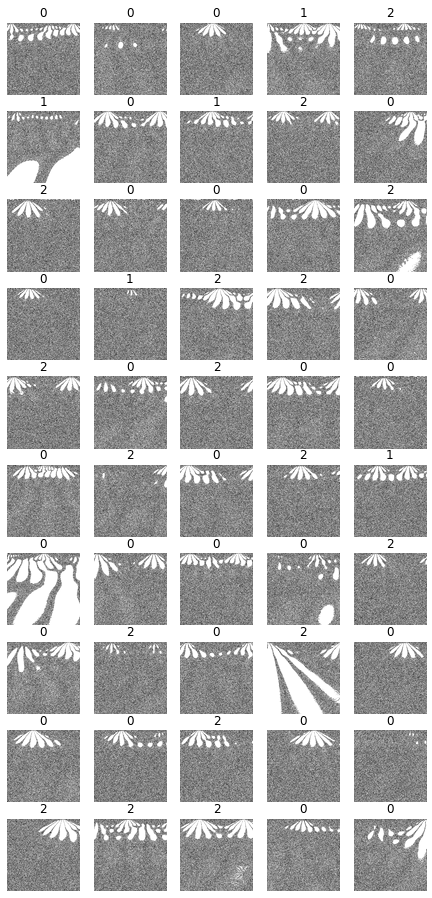

In [13]:
#Inspecting DATA
n_rows = 10
n_cols = 5
plt.figure(figsize=(n_cols*1.5, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow((X_full[index]*255).astype(np.uint8), cmap="binary", interpolation="spline36")
        plt.axis('off')
        plt.title(trainy3.iloc[index,0])
plt.show()